In [ ]:
import os

import cv2

import numpy as np

import matplotlib.pyplot as plt

from glob import glob

from sklearn.metrics import f1_score, jaccard_score, roc_curve, auc

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model

from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import img_to_array, load_img

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
# Drive'dan bağlantı (eğer veri oradaysa)
from google.colab import drive
drive.mount('/content/drive')

# Dataset dizini (kendi yoluna göre değiştir)
DATASET_DIR = '/content/drive/MyDrive/wood_dataset/wood'

# Görüntü yükleme fonksiyonu
def load_images_from_folder(folder_path, size=(256, 256)):
    image_paths = sorted(glob(os.path.join(folder_path, '*.jpg')))  # veya jpg
    images = []
    for path in image_paths:
        img = load_img(path, target_size=size, color_mode='grayscale')
        img = img_to_array(img) / 255.0
        images.append(img)
    return np.array(images)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Eğitim verisi (sadece good)
train_images = load_images_from_folder(os.path.join(DATASET_DIR, 'train/good'))

# Test verisi (good + defect)
test_good = load_images_from_folder(os.path.join(DATASET_DIR, 'test/good'))
test_defect = load_images_from_folder(os.path.join(DATASET_DIR, 'test/defect'))

# Maskeler (IoU için)
mask_defect = load_images_from_folder(os.path.join(DATASET_DIR, 'ground_truth/defect'))

# Şekil kontrolü
print(f"Train: {train_images.shape}, Test_good: {test_good.shape}, Test_defect: {test_defect.shape}")


Train: (70, 256, 256, 1), Test_good: (70, 256, 256, 1), Test_defect: (71, 256, 256, 1)


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 256, 256, 1)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 256, 256, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 32, 32, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_8 (UpSampling2D)       │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 64, 64, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_9 (UpSampling2D)       │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 128, 128, 32)        │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_10 (UpSampling2D)      │ (None, 256, 256, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 256, 256, 1)         │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 332,801 (1.27 MB)

 Trainable params: 332,801 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 18s 3s/step - loss: 0.0539 - val_loss: 0.0566 - learning_rate: 1.0000e-04
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - loss: 0.0519 - val_loss: 0.0522 - learning_rate: 1.0000e-04
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - loss: 0.0475 - val_loss: 0.0462 - learning_rate: 1.0000e-04
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - loss: 0.0424 - val_loss: 0.0392 - learning_rate: 1.0000e-04
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - loss: 0.0374 - val_loss: 0.0342 - learning_rate: 1.0000e-04
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 146ms/step - loss: 0.0366 - val_loss: 0.0335 - learning_rate: 1.0000e-04
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - loss: 0.0364 - val_loss: 0.0334 - learning_rate: 1.0000e-04
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - loss: 0.0345 - val_loss: 0.0336 - learning_rate: 1.0000e-04
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - loss: 0.0334 - val_loss: 0.0310 - learning_rate: 1.000

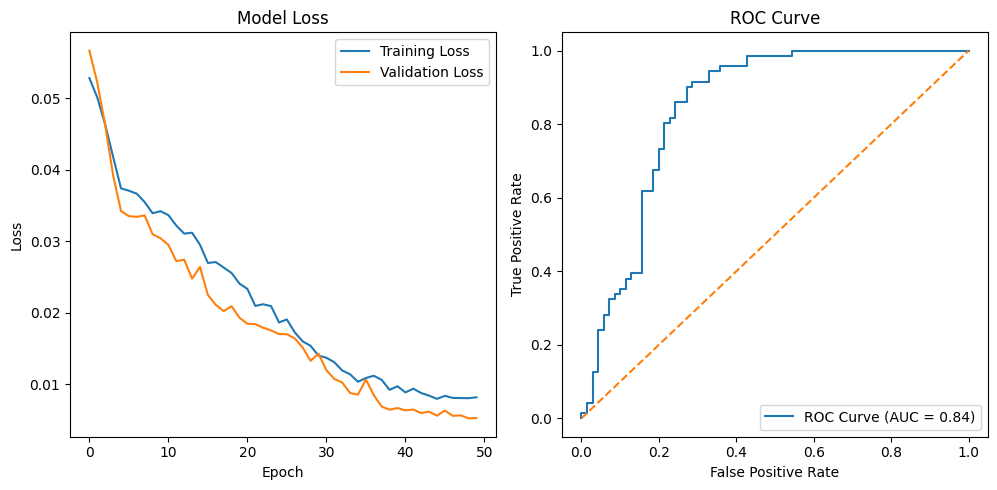

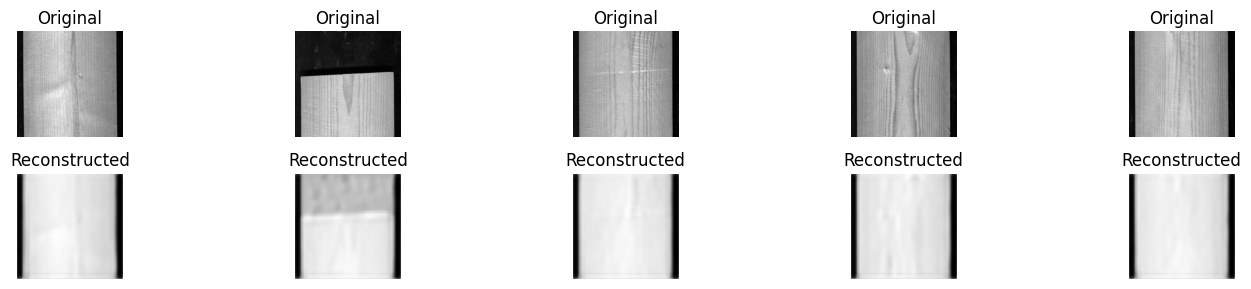

In [ ]:
X_train, X_val = train_test_split(

    train_images,

    test_size=0.1,  # %10 validation

    shuffle=True,   # Mutlaka karıştır

    random_state=42 # Tekrarlanabilirlik için

)


def build_advanced_autoencoder(input_shape):

    input_img = Input(shape=input_shape)



    # Encoder

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)

    x = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)

    x = MaxPooling2D((2, 2), padding='same')(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)

    encoded = MaxPooling2D((2, 2), padding='same')(x)


    # Decoder

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)

    x = UpSampling2D((2, 2))(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)

    x = UpSampling2D((2, 2))(x)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)

    x = UpSampling2D((2, 2))(x)

    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)


    autoencoder = Model(input_img, decoded)

    autoencoder.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')

    return autoencoder


# Data Augmentation

train_datagen = ImageDataGenerator(

    rotation_range=20,

    width_shift_range=0.2,

    height_shift_range=0.2,

    horizontal_flip=True

)


# Callbacks

early_stopping = EarlyStopping(

    monitor='val_loss',

    patience=10,

    restore_best_weights=True

)


reduce_lr = ReduceLROnPlateau(

    monitor='val_loss',

    factor=0.2,

    patience=5,

    min_lr=1e-5

)


# Gelişmiş Autoencoder

autoencoder = build_advanced_autoencoder((256, 256, 1))

autoencoder.summary()


# Eğitim

history = autoencoder.fit(

    train_datagen.flow(X_train, X_train, batch_size=16),

    validation_data=(X_val, X_val),

    epochs=50,

    callbacks=[early_stopping, reduce_lr],

    shuffle=True

)


# Gelişmiş Anomali Skoru Hesaplama

def compute_advanced_anomaly_score(original, reconstructed):

    # Çoklu metrik anomali skoru

    pixel_diff = np.mean(np.abs(original - reconstructed), axis=(1,2,3))

    global_diff = np.max(np.abs(original - reconstructed), axis=(1,2,3))

    variance_diff = np.var(np.abs(original - reconstructed), axis=(1,2,3))

    return (pixel_diff + global_diff + variance_diff) / 3


# Test görüntüleri

test_all = np.concatenate([test_good, test_defect])

reconstructed = autoencoder.predict(test_all)


# Anomali Skorları

scores = compute_advanced_anomaly_score(test_all, reconstructed)


# ROC Eğrisi ile Optimal Eşik

true_labels = np.array([0]*len(test_good) + [1]*len(test_defect))

fpr, tpr, thresholds = roc_curve(true_labels, scores)

optimal_idx = np.argmax(tpr - fpr)

optimal_threshold = thresholds[optimal_idx]


# Tahmin Etiketleri

pred_labels = (scores > optimal_threshold).astype(int)


# Performans Metrikleri

f1 = f1_score(true_labels, pred_labels)

roc_auc = auc(fpr, tpr)


print("Optimal Threshold:", optimal_threshold)

print("F1 Score:", f1)

print("ROC AUC:", roc_auc)


# Segmentasyon ve IoU Hesaplama

def get_binary_mask(original, reconstructed, threshold):

    diff = np.abs(original - reconstructed)

    mask = (diff > threshold).astype(np.uint8)

    return mask


# IoU Hesaplama

ious = []

threshold_pixel = 0.1  # piksel bazlı eşik


for i in range(min(len(reconstructed), len(mask_defect))):

    pred_mask = get_binary_mask(test_defect[i:i+1], reconstructed[i:i+1], threshold_pixel)[0]

    gt_mask = (mask_defect[i] > 0.1).astype(np.uint8)


    iou = jaccard_score(gt_mask.flatten(), pred_mask.flatten())

    ious.append(iou)


print("Mean IoU:", np.mean(ious))


# Görselleştirme

plt.figure(figsize=(15,5))

plt.subplot(131)

plt.plot(history.history['loss'], label='Training Loss')

plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Model Loss')

plt.xlabel('Epoch')

plt.ylabel('Loss')

plt.legend()


plt.subplot(132)

plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--')

plt.title('ROC Curve')

plt.xlabel('False Positive Rate')

plt.ylabel('True Positive Rate')

plt.legend()


plt.tight_layout()

plt.show()


# Örnek Görüntüleme

def plot_reconstruction(original, reconstructed, n=5):

    plt.figure(figsize=(15, 3))

    for i in range(n):

        # Orijinal

        plt.subplot(2, n, i+1)

        plt.imshow(original[i].squeeze(), cmap='gray')

        plt.title('Original')

        plt.axis('off')



        # Reconstruct

        plt.subplot(2, n, n+i+1)

        plt.imshow(reconstructed[i].squeeze(), cmap='gray')

        plt.title('Reconstructed')

        plt.axis('off')

    plt.tight_layout()

    plt.show()


# İlk 5 test görüntüsü için rekonstrüksiyon

plot_reconstruction(test_all[:5], reconstructed[:5])